In [1]:
import sys
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import scipy.stats as stats

import pystan

sys.path.append("..")
import util
from util.plot import Background

%matplotlib inline

In [2]:
df = pd.read_pickle("../run/solo/df-loo.pkl")
df = df[df.onset == "INC"]

df['pstatinf'] = np.where(df.seizing, df.pszinf, 1. - df.pszinf)
df['pstatemu'] = np.where(df.seizing, df.pszemu, 1. - df.pszemu)
df['pstatemw'] = np.where(df.seizing, df.pszemw, 1. - df.pszemw)

# Differences in features
df['pstat_iu'] = df.pstatinf - df.pstatemu
df['pstat_iw'] = df.pstatinf - df.pstatemw
df['pt05_iu'] = df.pt05inf - df.pt05emu
df['pt05_iw'] = df.pt05inf - df.pt05emw

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [3]:
# Add connection strengths
df['w_obs'] = 0.
df['w_all'] = 0.

for i, (subject, rid) in df[['subject', 'rid']].drop_duplicates().iterrows():
    indata = util.io.rload(f"../run/solo/INC/vep/{subject}/input/r{rid:02d}_all.R")
    w = indata['w']
    
    reg_obs = np.concatenate([indata['reg_ns'], indata['reg_sz']]).astype(int)
    for region in df[(df.subject == subject) & (df.rid == rid)].region:
        mask = (df.subject == subject) & (df.rid == rid) & (df.region == region)
        df.loc[mask, 'w_obs'] = np.sum(w[region, reg_obs]) + np.sum(w[reg_obs, region])
        df.loc[mask, 'w_all'] = np.sum(w[region, :]) + np.sum(w[:, region])

In [4]:
df = df.drop(columns=['onset', 'observed', 'ttru', 'rhat', 'neff', 'pez', 'cinf', 'firstseizing', 'pfirst',
                      'pszinf', 'pszemu', 'pszemw', 'pdinf', 'pdemu', 'pdemw',
                      'pt10inf', 'pt10emu', 'pt10emw', 'pt20inf', 'pt20emu', 'pt20emw'])

subjects = list(df.subject.unique())

In [5]:
model_code = """
data {
    int nsubjects;
    int nseizures[nsubjects];
    int nregions[nsubjects, max(nseizures)];    
    int ncat;
    
    int cat[nsubjects, max(nseizures), max(to_array_1d(nregions))];
    real y[nsubjects, max(nseizures), max(to_array_1d(nregions))];
    real n[nsubjects, max(nseizures), max(to_array_1d(nregions))];
    real f[nsubjects, max(nseizures)];
}

parameters {
    vector<lower=0>[ncat] sigreg;
    vector<lower=0>[ncat] sigszr;
    vector<lower=0>[ncat] sigsub;
    
    vector[ncat] a;
    vector[ncat] b;
    vector[ncat] cbb;

    vector[ncat] etacb[nsubjects];
    vector[ncat] etac[nsubjects, max(nseizures)];
}

model {
    int icat;
    vector[ncat] cb[nsubjects];
    vector[ncat] c[nsubjects, max(nseizures)];
    
    sigreg ~ normal(0, 1);
    sigszr ~ normal(0, 1);
    sigsub ~ normal(0, 1);

    a ~ normal(0, 1);
    b ~ normal(0, 1);
    cbb ~ normal(0, 1);
    
    for (i in 1:ncat) {
        to_array_1d(etacb[:,i]) ~ normal(0, 1);
        to_array_1d(etac[:,:,i]) ~ normal(0, 1);
    }

    for (i in 1:nsubjects) {
        cb[i] = cbb + sigsub .* etacb[i];
    
        for (j in 1:nseizures[i]) {
            c[i, j] = cb[i] + sigszr .* etac[i, j];
        
            for (k in 1:nregions[i,j]) {
                icat = cat[i,j,k];
                y[i,j,k] ~ normal(f[i,j]*a[icat] + n[i,j,k]*b[icat] + c[i,j,icat], sigreg[icat]);
            }
        }
    }
}

generated quantities {
    vector[ncat] cb[nsubjects];
    vector[ncat] c[nsubjects, max(nseizures)];
    
    for (i in 1:nsubjects) {
        cb[i] = cbb + sigsub .* etacb[i];    
        for (j in 1:nseizures[i]) {
            c[i, j] = cb[i] + sigszr .* etac[i, j];
        }
    }
}

"""

model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ece3880013e6b9bd7abf4f8e435c7c48 NOW.


In [6]:
def build_data(df, var, categories):
    df = df.copy()
    df = df[~df[var].isna()]
    
    df['cat'] = 0
    if categories == "sz-ns":
        df.loc[ df.seizing, 'cat'] = 1
        df.loc[~df.seizing, 'cat'] = 2
        ncat = 2
    elif categories == "sz":
        df.loc[df.seizing, 'cat'] = 1
        ncat = 1
    else:
        raise ValueError("Unexpected config '{config}'")    
    
    subjects = df.subject.unique()
    nsubjects = len(subjects)
    max_nseizures = int(df.groupby(['subject']).aggregate({'rid': 'nunique'}).max())
    max_nregions = int(df.groupby(['subject', 'rid']).aggregate({'region': 'count'}).max())

    nseizures = np.zeros(nsubjects, dtype=int)
    nregions = np.zeros((nsubjects, max_nseizures), dtype=int)
    y = np.full((nsubjects, max_nseizures, max_nregions), np.nan, dtype=float)
    n = np.zeros((nsubjects, max_nseizures, max_nregions), dtype=float)
    f = np.zeros((nsubjects, max_nseizures), dtype=float)
    cat = np.zeros((nsubjects, max_nseizures, max_nregions), dtype=int)

    for i, subject in enumerate(subjects):
        dff = df[df.subject == subject]
        nseizures[i] = len(dff.rid.unique())
        for j, rid in enumerate(dff.rid.unique()):
            dfff = dff[(dff.rid == rid)]
            nregs = len(dfff)
            nregions[i,j] = nregs
            y[i,j,:nregs] = dfff[var]
            n[i,j,:nregs] = dfff['w_all']
            f[i,j] = dfff['fracsz'].iloc[0]
            cat[i,j,:nregs] = dfff['cat']

    data = {
        "nsubjects": nsubjects,
        "nseizures": nseizures,
        "nregions": nregions,
        "ncat": ncat,

        "cat": cat,
        "y": y,
        "n": n,
        "f": f,
    }
    return data


def postpred_seizure_level(data, res):
    y = data['y']
    nsubjects = data['nsubjects']
    nseizures = data['nseizures']
    nregions = data['nregions']
    
    nsamples = len(res['lp__'])
    ypred = np.full((nsamples, y.shape[0], y.shape[1], y.shape[2]), np.nan)

    a = res['a']
    b = res['b']
    c = res['c']
    sigreg = res['sigreg']
    sigszr = res['sigszr']
    sigsub = res['sigsub']

    eta = stats.norm(0,1).rvs(size=ypred.shape)

    for i in range(nsubjects):
        print(i, end=' ', flush=True)
        for j in range(nseizures[i]):
            for k in range(nregions[i,j]):
                for ii in range(nsamples):
                    ybar = (  (1-s[i,j,k]) * (f[i,j]*a[ii,0] + n[i,j,k]*b[ii,0] + c[ii,0,i,j])
                            +    s[i,j,k]  * (f[i,j]*a[ii,1] + n[i,j,k]*b[ii,1] + c[ii,1,i,j]));

                    ypred[ii,i,j,k] = ybar + eta[ii,i,j,k]*((1-s[i,j,k])*sigreg[ii,0] + s[i,j,k]*sigreg[ii,1])
                    
    return ypred

def bootstrap(y, s, nsubjects, nseizures, nbootstrap):
    ymean_subject = np.full((nbootstrap, 2, y.shape[0]), np.nan)
    ymean_seizure = np.full((nbootstrap, 2, y.shape[0], y.shape[1]), np.nan)

    for ind in [0, 1]:
        for i in range(nsubjects):
            ysub = y[i]
            ysub = ysub[(~np.isnan(ysub)) & (s[i] == ind)]
            ymean_subject[:, ind, i] = np.mean(np.random.choice(ysub, size=(nbootstrap, len(ysub)), replace=True),
                                             axis=1)

            for j in range(nseizures[i]):
                yszr = y[i,j]
                yszr = yszr[~np.isnan(yszr) & (s[i,j] == ind)]
                ymean_seizure[:, ind, i, j] = np.mean(
                    np.random.choice(yszr, size=(nbootstrap, len(yszr)), replace=True),
                    axis=1)
                
    return ymean_subject, ymean_seizure


def correct_linreg(data):
    y = data['y']
    s = data['s']
    n = data['n']
    f = data['f']
    f = np.repeat(f[:,:,None], y.shape[-1], axis=2)

    masksz = (~np.isnan(y) & (s == 1))
    maskns = (~np.isnan(y) & (s == 0))
    linreg_sz = LinearRegression().fit(np.vstack([f[masksz], n[masksz]]).T, y[masksz])
    linreg_ns = LinearRegression().fit(np.vstack([f[maskns], n[maskns]]).T, y[maskns])
    
    nsubjects = data['nsubjects']
    nseizures = data['nseizures']
    nregions = data['nregions']
    
    ycor = np.full(y.shape, np.nan)

    for i in range(nsubjects):
        for j in range(nseizures[i]):
            for k in range(nregions[i,j]):
                if s[i,j,k] == 0:
                    ycor[i,j,k] = y[i,j,k] - linreg_ns.predict([[f[i,j,k], n[i,j,k]]])
                else:
                    ycor[i,j,k] = y[i,j,k] - linreg_sz.predict([[f[i,j,k], n[i,j,k]]])
                
    return ycor

In [7]:
def plot_results(datas, ress, varnames, title, subjects, filename):
    
    plt.figure(figsize=(14, 18))
    gs = GridSpec(1, 8, wspace=0.05, width_ratios=[1, 1, 0.4, 1, 1, 0.4, 1, 1],
                  left=0.06, right=0.99, top=0.92, bottom=0.03)
    plt.suptitle(title, fontsize=24)

    colors = ['tab:red', 'tab:blue']
    
    for k, (data, res, varname) in enumerate(zip(datas, ress, varnames)):
        c   = res['c']
        cb  = res['cb']
        cbb = res['cbb']
        nsubjects = data['nsubjects']
        nseizures = data['nseizures']
        ncat = data['ncat']
        
        # Fitted confidence intervals
        for icat in range(ncat):
            plt.subplot(gs[0, 3*k + icat])

            for i in range(nsubjects):
                plt.plot(np.percentile(cb[:, i, icat], [2.5, 97.5]), [i, i], lw=2, color=colors[icat])
                plt.scatter(np.percentile(cb[:, i, icat], 50), i, color=colors[icat], s=30)
                for j in range(nseizures[i]):
                    plt.plot(np.percentile(c[:, i, j, icat], [2.5, 97.5]), [i+0.12+0.08*j,i+0.12+0.08*j], lw=0.5, 
                             color=colors[icat])

            plt.axvline(np.mean(cbb[:, icat]), color='k')
            plt.ylim(nsubjects, -1)
            if icat == 0: plt.yticks(np.r_[:nsubjects], subjects) 
            else:         plt.yticks([])
            plt.title("Seizing regions" if icat == 0 else "Non-seizing regions")
            plt.xlabel("$\\bar{c}_i$, $c_{ij}$")
        
    bg = Background(visible=False)
    titlepos = [0.190, 0.525, 0.863]
    for pos, data, varname in zip(titlepos, datas, varnames):
        offset = -0.07 if (data['ncat'] == 1) else 0.
        plt.text(pos+offset, 0.94, varname, fontsize=16, va='center', ha='center')
    
    plt.savefig(filename)

In [8]:
def collect_summary(data, fit, stat):
    if stat == 'Rhat':
        ind = -1
    elif stat == 'neff':
        ind = -2
    else: 
        raise ValueError(f"Unexpected stat {stat}")
    
    summary = fit.summary()
    rownames = summary['summary_rownames']
    values_all = summary['summary'][:, ind]
    
    nseizures = data['nseizures']
    values = []
    for rowname, value in zip(rownames, values_all):
        if rowname == "lp__": continue
        
        match = re.match("([a-zA-Z]+)\[(.*)\]", rowname)
        param, indices = match.groups()
        
        if param in ['a', 'b', 'sigreg', 'sigszr', 'sigsub', 'cbb', 'etacb']:
            values.append(value)
        elif param == "etac":
            isub, iszr, icat = [int(a)-1 for a in indices.split(",")]
            if iszr < nseizures[isub]:
                values.append(value)
    
    return np.array(values)


def calc_postpred_group(df, data, res):
    sigsub = res['sigsub']
    sigszr = res['sigszr']
    sigreg = res['sigreg']
    cbb = res['cbb']
    a = res['a']
    b = res['b']
    
    nsamples, ncat = sigsub.shape

    fsims = np.linspace(0, 1, 20)
    ysimsf = np.zeros((nsamples, ncat, len(fsims)))
    ns = df.w_all.sample(frac=1)
    eta = stats.norm(0,1).rvs(size=(nsamples, 3, ncat))
    for icat in range(ncat):
        for j, fsim in enumerate(fsims):
            for i in range(nsamples):
                nsim = ns.iloc[i]
                csub = eta[i, 0, icat]*sigsub[i, icat] + cbb[i, icat]
                cszr = eta[i, 1, icat]*sigszr[i, icat] + csub
                creg = eta[i, 2, icat]*sigreg[i, icat] + cszr
                ysimsf[i, icat, j] = fsim * a[i, icat] + nsim * b[i, icat] + creg

    nsims = np.linspace(0, 1, 20)
    ysimsn = np.zeros((nsamples, ncat, len(nsims)))
    fs = df.fracsz.sample(frac=1)
    eta = stats.norm(0,1).rvs(size=(nsamples, 3, ncat))
    for icat in range(ncat):
        for j, nsim in enumerate(nsims):
            for i in range(nsamples):
                fsim = fs.iloc[i]
                csub = eta[i, 0, icat]*sigsub[i, icat] + cbb[i, icat]
                cszr = eta[i, 1, icat]*sigszr[i, icat] + csub
                creg = eta[i, 2, icat]*sigreg[i, icat] + cszr
                ysimsn[i, icat, j] = fsim * a[i, icat] + nsim * b[i, icat] + creg
                
    return fsims, ysimsf, nsims, ysimsn


def analyze_results(df, data, res, fit, varname, filename):
    plt.figure(figsize=(16, 3))
    plt.suptitle(varname)
    
    # Inferred sigmas
    sigreg = res['sigreg']
    sigszr = res['sigszr']
    sigsub = res['sigsub']
    
    ncat = sigreg.shape[1]
    categories = ["Seizing", "Non-seizing"]

    for ind in range(ncat):
        plt.subplot(1, 5, ind+1)
        plt.title(categories[ind])
        plt.hist([sigreg[:, ind], sigszr[:, ind], sigsub[:, ind]],
                 bins=np.linspace(0, 0.25, 21), label=["region", "seizure", "subject"], density=True);
        plt.legend(title="sigma")

    # Posterior predictions
    fsims, ysimsf, nsims, ysimsn = calc_postpred_group(df, data, res)

    colors = ['r', 'b']
    plt.subplot(1,5,3)
    for ind in range(ncat):
        color = colors[ind]
        plt.plot(fsims, np.percentile(ysimsf[:, ind, :], 50, axis=0), color=color)
        plt.fill_between(fsims, *np.percentile(ysimsf[:, ind, :], [5, 95], axis=0), color=color, alpha=0.3)
    plt.axhline(0., color='k')
    plt.xlabel("Fraction seizing")

    plt.subplot(1,5,4)
    for ind in range(ncat):
        color = colors[ind]        
        plt.plot(nsims, np.percentile(ysimsn[:, ind, :], 50, axis=0), color=color)
        plt.fill_between(nsims, *np.percentile(ysimsn[:, ind, :], [5, 95], axis=0), color=color, alpha=0.3)
    plt.axhline(0., color='k')
    plt.xlabel("Node stregth")
    
    # Stats
    plt.subplot(1,5,5)

    rhat = collect_summary(data, fit, 'Rhat')
    neff = collect_summary(data, fit, 'neff')
    plt.text(0.1, 0.9, f"N params:    {len(rhat)}")
    plt.text(0.1, 0.7, f"Max Rhat:    {np.max(rhat):6.3f}")
    plt.text(0.1, 0.6, f"Rhat > 1.05: {np.sum(rhat > 1.05)}")
    plt.text(0.1, 0.4, f"Min neff:    {np.min(neff):7.2f}")
    plt.text(0.1, 0.3, f"neff < 50:   {np.sum(neff < 50)}")
    plt.xticks([]); plt.yticks([]);
    plt.tight_layout()
    plt.savefig(filename)

## State prediction accuracy

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


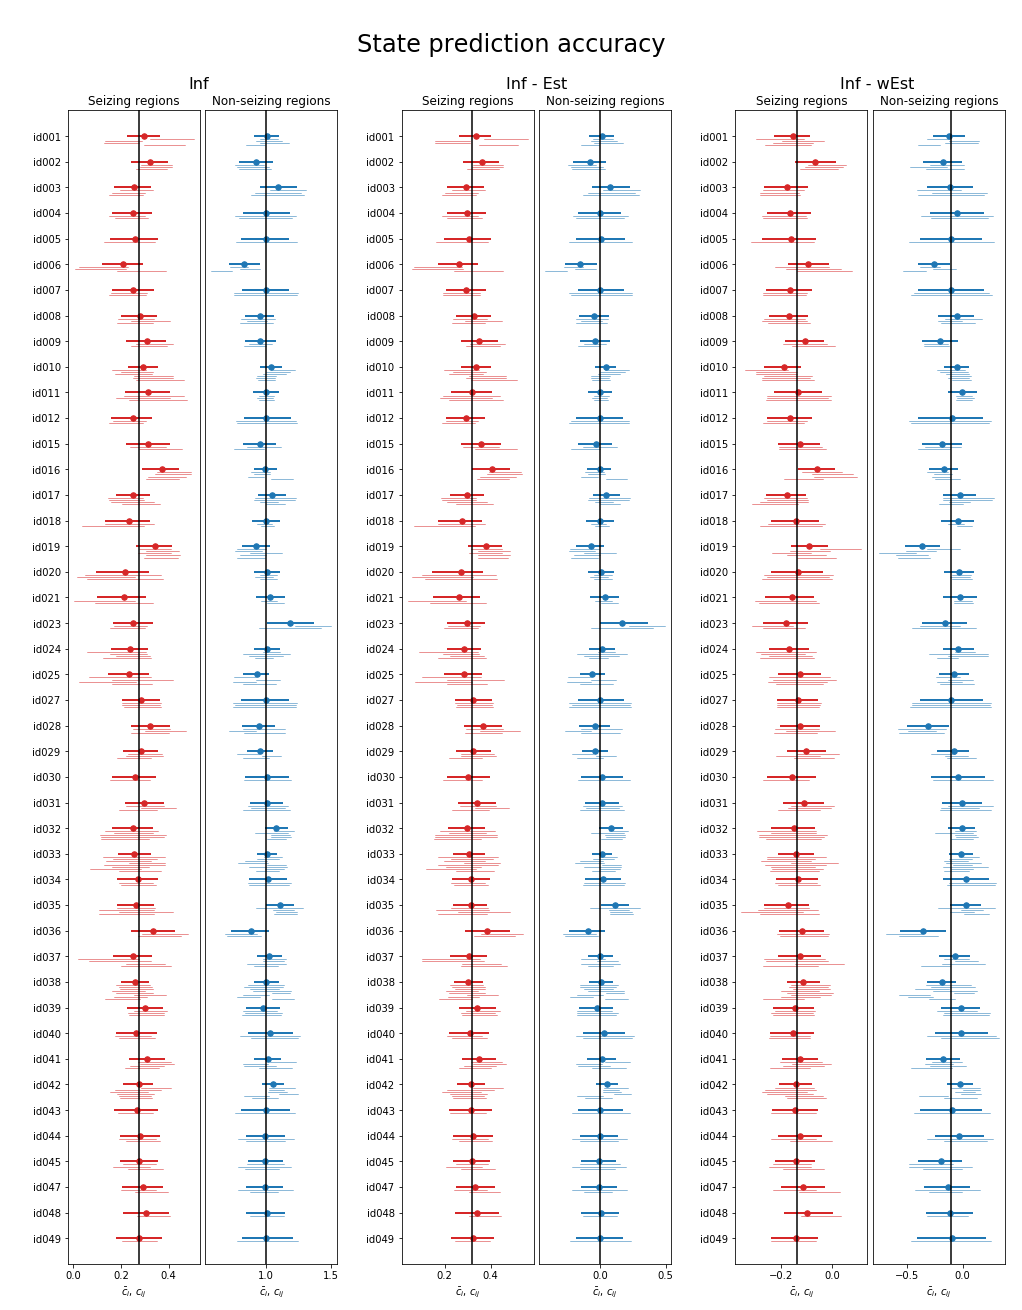

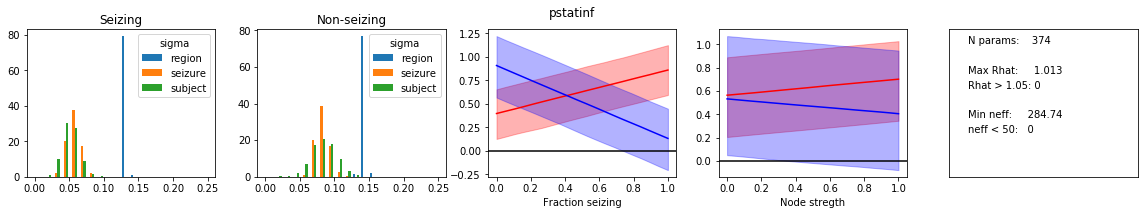

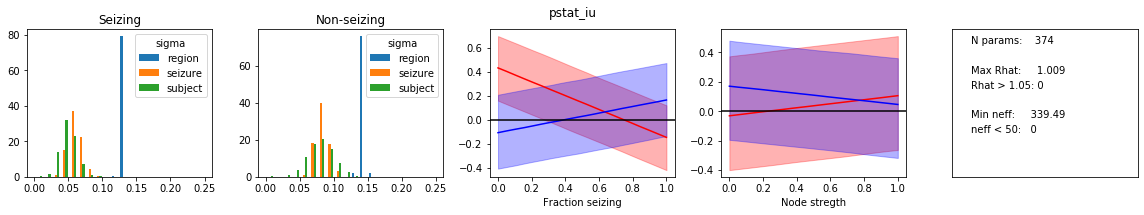

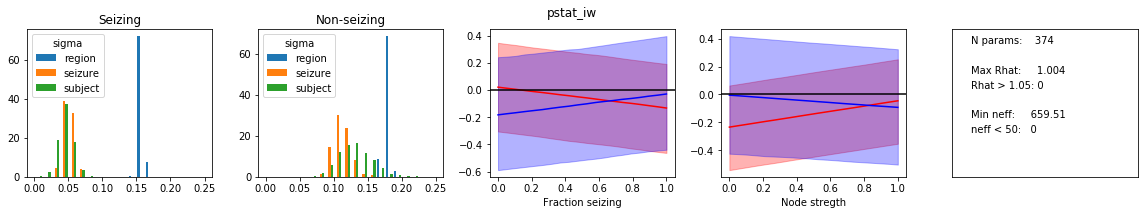

In [9]:
variables = ['pstatinf', 'pstat_iu', 'pstat_iw']
title = "State prediction accuracy"
shorttitle = "pstat"
varnames  = ["Inf", "Inf - Est", "Inf - wEst"]
subjects = list(df.subject.unique())

datas = [build_data(df, var, "sz-ns") for var in variables]
fits = [model.sampling(data=data, iter=1000, chains=4, seed=42) for data in datas]
ress = [fit.extract() for fit in fits]

plot_results(datas, ress, varnames, title, subjects, f"img/hierarchical-analysis-{shorttitle}.pdf")

for data, res, fit, var in zip(datas, ress, fits, variables):
    analyze_results(df, data, res, fit, var, f"img/hierarchical-analysis-details-{var}.pdf")

## Onset prediction accuracy

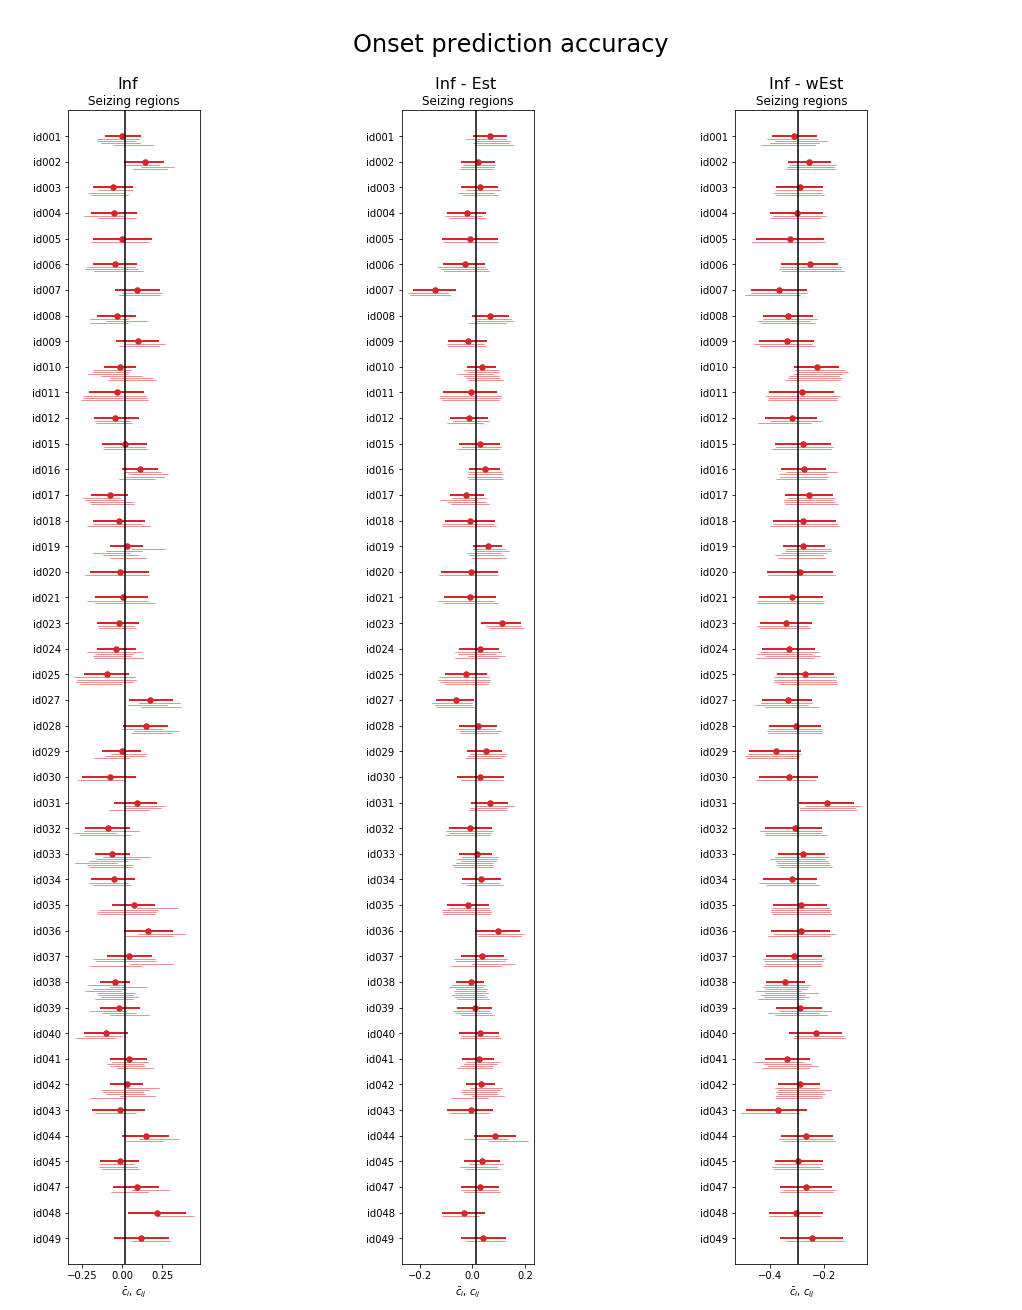

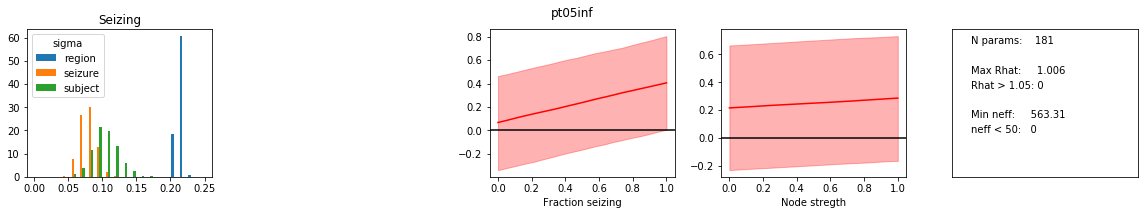

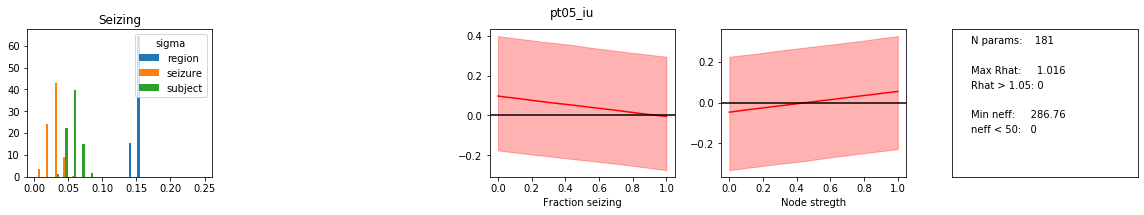

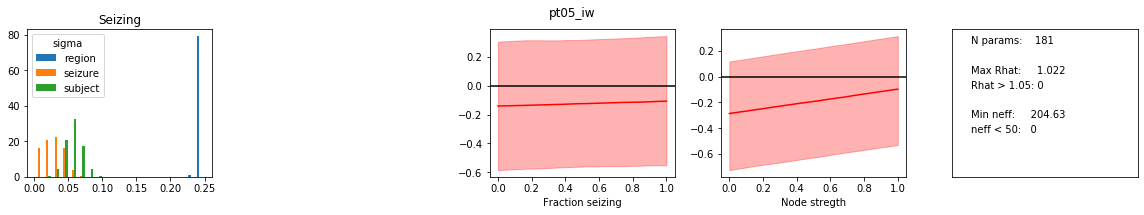

In [10]:
variables = ['pt05inf', 'pt05_iu', 'pt05_iw']
title = "Onset prediction accuracy"
shorttitle = "pt05"
varnames  = ["Inf", "Inf - Est", "Inf - wEst"]
subjects = list(df.subject.unique())

datas = [build_data(df, var, "sz") for var in variables]
fits = [model.sampling(data=data, iter=1000, chains=4, seed=42) for data in datas]
ress = [fit.extract() for fit in fits]

plot_results(datas, ress, varnames, title, subjects, f"img/hierarchical-analysis-{shorttitle}.pdf")

for data, res, fit, var in zip(datas, ress, fits, variables):
    analyze_results(df, data, res, fit, var, f"img/hierarchical-analysis-details-{var}.pdf")